Installing the Earth Engine API

In [1]:
%pip install earthengine-api

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%pip install rasterio

In [29]:
%matplotlib inline

In [5]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


Defining the geographical region and time period of study:

In [6]:
import ee
# Define the bounding box roughly over Siberia
siberia = ee.Geometry.Rectangle([60, 57, 140, 72])  # (lon_min, lat_min, lon_max, lat_max)
# Time range
start_date = '2013-01-01'
end_date = '2023-12-31'

In [8]:
# Loading MODIS Albedo data
modis_albedo = ee.ImageCollection("MODIS/006/MCD43A3").filterDate(start_date, end_date).filterBounds(siberia)
# Print how many images were found in the given spatio-temporal bounds
print("Number of images:", modis_albedo.size().getInfo())

Number of images: 3693


In [21]:
#Defining seasonal tags
def get_season(month):
    if month in [12, 1, 2]:
        return 'snow'
    elif month in [6, 7, 8]:
        return 'leaf'
    else:
        return 'transition'
def compute_mean_albedo(image):
    # Get image date info
    date = ee.Date(image.get('system:time_start'))
    year = date.get('year')
    month = date.get('month')
    
    # Reduce region to get mean albedo over Siberia
    mean_dict = image.reduceRegion(reducer=ee.Reducer.mean(),geometry=siberia,scale=500,maxPixels=1e13)
    return ee.Feature(None, {'mean_albedo': mean_dict.get('Albedo_WSA_shortwave'),'year': year,'month': month,'season': get_season_from_month(month)})
def get_season_from_month(month):
    return ee.Algorithms.If(
        ee.Number(month).eq(12).Or(ee.Number(month).lte(2)), 'snow',
        ee.Algorithms.If(
            ee.Number(month).gte(6).And(ee.Number(month).lte(8)), 'leaf',
            'transition'
        )
    )
features = modis_albedo.map(compute_mean_albedo)
task = ee.batch.Export.table.toDrive(
    collection=features,
    description='Siberia_Monthly_Albedo',
    fileFormat='CSV'
)
task.start() #Tells the Earth Engine to create a CSV file with the aforesaid fields and classifications

Importing the csv file "Siberia_Albedo_Seasonal.csv"

In [ ]:
import pandas as pd

albedo_df = pd.read_csv("Siberia_Albedo_Seasonal.csv")
print(albedo_df)

Monthly average

In [ ]:
alb_monthly_avg = albedo_df.groupby('month')['mean_albedo'].mean().reset_index()
print(alb_monthly_avg)

Seasonal average

In [ ]:
seasonal_avg = albedo_df.groupby('season')['mean_albedo'].mean().reset_index()
print(seasonal_avg)

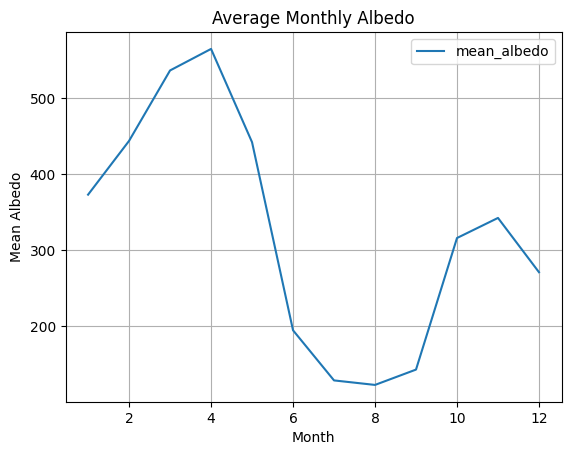

In [102]:
#Plotting monthly albedo mean
import matplotlib.pyplot as plt

alb_monthly_avg.plot(x='month', y='mean_albedo')
plt.title('Average Monthly Albedo')
plt.xlabel('Month')
plt.ylabel('Mean Albedo')
plt.grid(True)
plt.show()

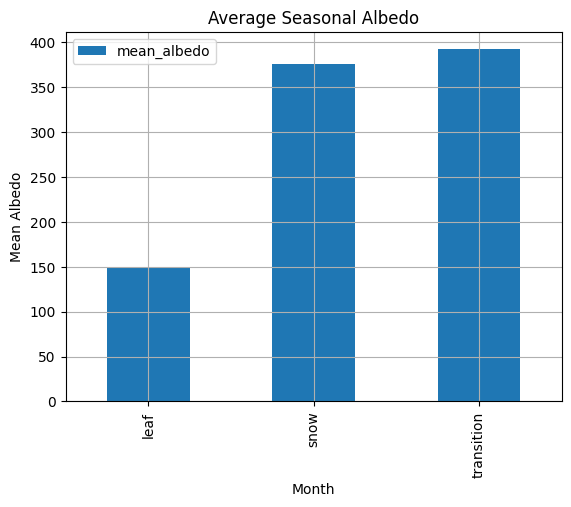

In [173]:
#Plotting seasonal albedo mean
import matplotlib.pyplot as plt

seasonal_avg.plot(x='season', y='mean_albedo', kind='bar')
plt.title('Average Seasonal Albedo')
plt.xlabel('Month')
plt.ylabel('Mean Albedo')
plt.grid(True)
plt.show()

Importing CERES NetCDF file

In [ ]:
import xarray as xr
import pandas as pd

# Loading NetCDF
ds = xr.open_dataset("CERES_EBAF_TOA_OLR_Siberia.nc")

# Extracting OLR
olr = ds['toa_lw_all_mon']
olr_clr=ds['toa_lw_clr_c_mon']
# Mean over lat/lon
monthly_olr = olr.mean(dim=['lat', 'lon'])
monthly_olr_clr=olr_clr.mean(dim=['lat', 'lon'])
# Converting to DataFrame
olr_df = monthly_olr.to_dataframe().reset_index()
olr_clr_df =monthly_olr_clr.to_dataframe().reset_index()
# Add month/year columns
olr_df['month'] = olr_df['time'].dt.month
olr_df['year'] = olr_df['time'].dt.year
olr_clr_df['month'] = olr_clr_df['time'].dt.month
olr_clr_df['year'] = olr_clr_df['time'].dt.year
#Monthly average across years
olr_monthly_avg = olr_df.groupby('month')['toa_lw_all_mon'].mean().reset_index()
print(olr_monthly_avg)
olr_clr_monthly_avg = olr_clr_df.groupby('month')['toa_lw_clr_c_mon'].mean().reset_index()

For Solar FLux data

In [ ]:
import xarray as xr
import pandas as pd

# Load NetCDF
ds = xr.open_dataset("CERES_EBAF_TOA_OLR_Siberia.nc")

# Extract OLR (this might be named like 'toa_lw_all_mon')
sol = ds['solar_mon']
# Mean over lat/lon
monthly_sol= sol.mean(dim=['lat', 'lon'])
# Convert to DataFrame
solar_df = monthly_sol.to_dataframe().reset_index()
# Add month/year columns
solar_df['month'] = solar_df['time'].dt.month
solar_df['year'] = solar_df['time'].dt.year
# Optional: Monthly average across years
sol_monthly_avg = solar_df.groupby('month')['solar_mon'].mean().reset_index()

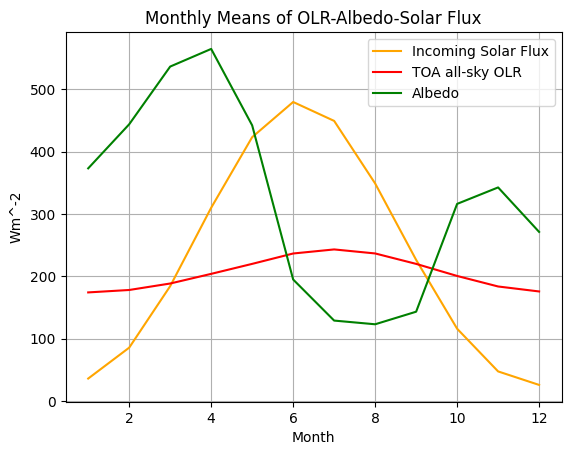

In [174]:
#Plotting
import matplotlib.pyplot as plt
plt.plot(sol_monthly_avg['month'],sol_monthly_avg['solar_mon'],label='Incoming Solar Flux',color='orange')
plt.plot(olr_monthly_avg['month'],olr_monthly_avg['toa_lw_all_mon'],label='TOA all-sky OLR',color='red')
plt.plot(alb_monthly_avg['month'],alb_monthly_avg['mean_albedo'],label='Albedo',color='green')
plt.title('Monthly Means of OLR-Albedo-Solar Flux')
plt.xlabel('Month')
plt.ylabel('Wm^-2')
plt.grid(True)
plt.legend()
plt.show()

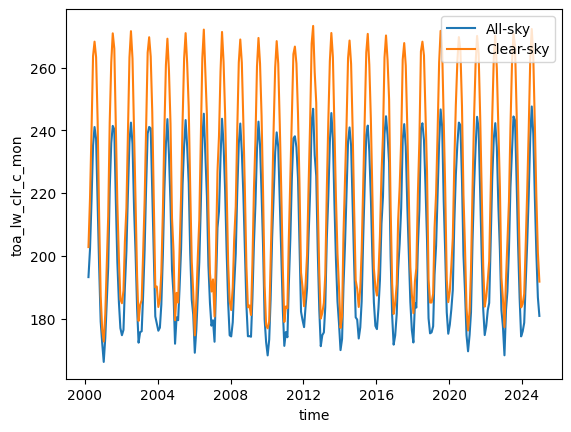

In [108]:
#Plotting OLR difference
ds['toa_lw_all_mon'].mean(dim=['lat', 'lon']).plot(label='All-sky')
ds['toa_lw_clr_c_mon'].mean(dim=['lat', 'lon']).plot(label='Clear-sky')
diff=ds['toa_lw_clr_c_mon'].mean(dim=['lat', 'lon'])-ds['toa_lw_all_mon'].mean(dim=['lat', 'lon'])
diff.plot(label='diff')
plt.legend()

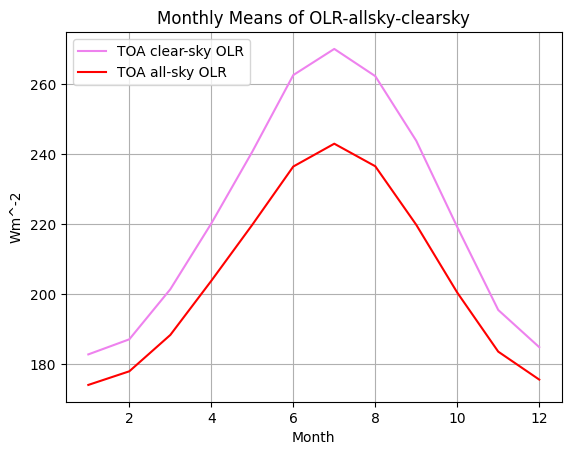

In [111]:
#Monthly difference plot
plt.plot(olr_clr_monthly_avg['month'],olr_clr_monthly_avg['toa_lw_clr_c_mon'],label='TOA clear-sky OLR',color='violet')
plt.plot(olr_monthly_avg['month'],olr_monthly_avg['toa_lw_all_mon'],label='TOA all-sky OLR',color='red')
plt.title('Monthly Means of OLR-allsky-clearsky')
plt.xlabel('Month')
plt.ylabel('Wm^-2')
plt.grid(True)
plt.legend()
plt.show()

For yearly trends

In [68]:
albedo_yearly = albedo_df.groupby('year')['mean_albedo'].mean().reset_index()
olr_yearly = olr_df.groupby('year')['toa_lw_all_mon'].mean().reset_index()
solar_yearly = solar_df.groupby('year')['solar_mon'].mean().reset_index()

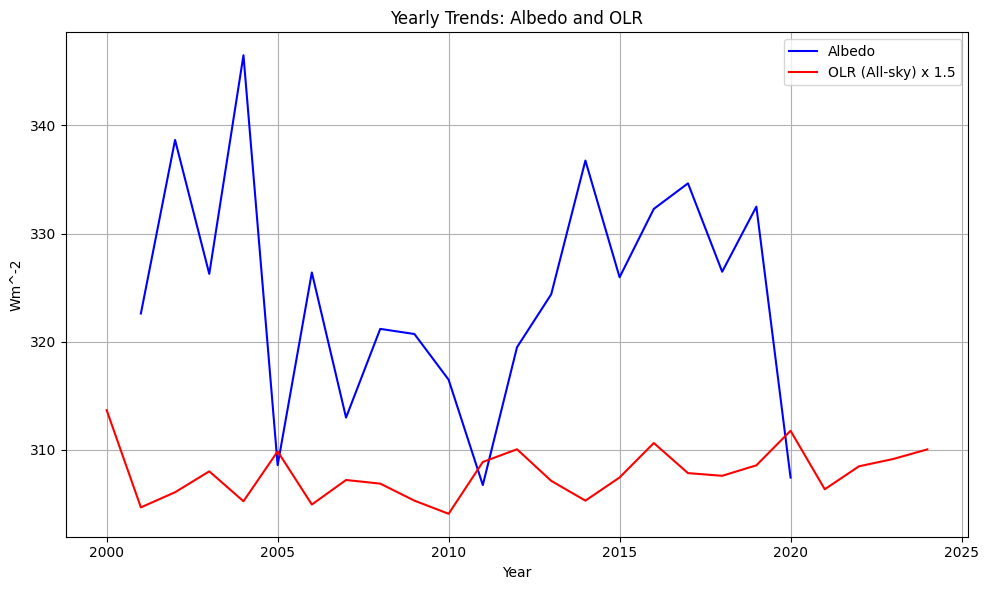

In [114]:
#Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(albedo_yearly['year'], albedo_yearly['mean_albedo'], label='Albedo', color='blue')
plt.plot(olr_yearly['year'], olr_yearly['toa_lw_all_mon']*1.5, label='OLR (All-sky) x 1.5', color='red')

plt.title('Yearly Trends: Albedo and OLR')
plt.xlabel('Year')
plt.ylabel('Wm^-2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Extracting NDVI data from Earth Engine MODIS

In [ ]:
import ee
ee.Initialize()
siberia = ee.Geometry.Rectangle([60, 57, 140, 72])

# Load MODIS NDVI dataset
modis_ndvi = ee.ImageCollection("MODIS/006/MOD13A2") \
    .filterBounds(siberia) \
    .select('NDVI')

# Function to calculate annual mean NDVI
def annual_ndvi(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    return modis_ndvi.filterDate(start, end).mean() \
        .set('year', year)

# Generate images from 2001 to 2021
years = ee.List.sequence(2001, 2021)
annual_ndvi_ic = ee.ImageCollection(years.map(annual_ndvi))

In [73]:
# Function to get mean NDVI per year
def reduce_to_mean(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=siberia,
        scale=1000,
        maxPixels=1e13
    )
    return ee.Feature(None, {
        'year': image.get('year'),
        'mean_ndvi': stats.get('NDVI')
    })

# Map and collect as feature collection
ndvi_fc = annual_ndvi_ic.map(reduce_to_mean)

Extracting as csv file

In [74]:
task = ee.batch.Export.table.toDrive(
    collection=ndvi_fc,
    description='Annual_NDVI_Siberia',
    fileFormat='CSV'
)
task.start()

Reading the NDVI CSV file

In [ ]:
import pandas as pd

ndvi_df = pd.read_csv('Annual_NDVI_Siberia.csv')
ndvi_df['year'] = ndvi_df['year'].astype(int)
print(ndvi_df)

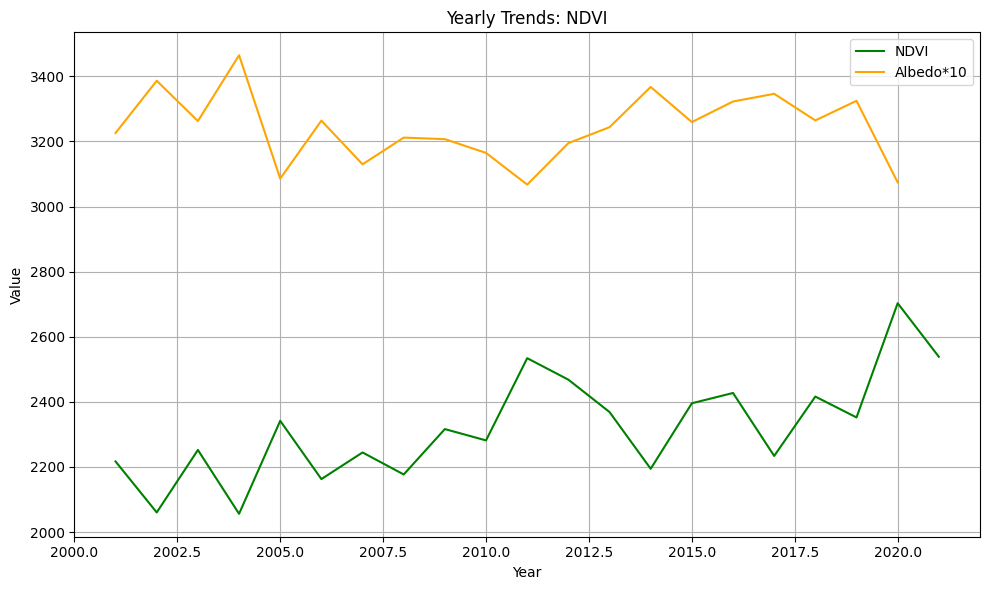

In [117]:
#Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(ndvi_df['year'], ndvi_df['mean_ndvi'], label='NDVI', color='green')
plt.plot(albedo_yearly['year'], albedo_yearly['mean_albedo']*10, label='Albedo*10', color='orange')

plt.title('Yearly Trends: NDVI')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
landcover = ee.ImageCollection("MODIS/006/MCD12Q1") \
    .filterBounds(siberia) \
    .filterDate('2001-01-01', '2021-12-31') \
    .select('LC_Type1')

c:\Users\ritob\AppData\Local\Programs\Python\Python311\Lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MCD12Q1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1

  warnings.warn(warning, category=DeprecationWarning)


Extracting landcover data, first selecting categories

In [85]:
def green_cover_fraction(image):
    year = ee.Date(image.get('system:time_start')).get('year')
    
    green_classes = [1, 2, 3, 4, 5, 6, 7]  # Forests, shrubland, big grasslands
    green_mask = image.remap(green_classes, [1]*len(green_classes), 0).rename('green_mask')

    area_image = green_mask.multiply(ee.Image.pixelArea())

    green_area = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=siberia,
        scale=500,
        maxPixels=1e13
    ).get('green_mask')

    return ee.Feature(None, {
        'year': year,
        'green_area_m2': green_area
    })

Extracting as CSV

In [87]:
features = landcover.map(green_cover_fraction)

task = ee.batch.Export.table.toDrive(
    collection=ee.FeatureCollection(features),
    description='MODIS_LandCover_GreenArea_Siberia',
    fileFormat='CSV'
)
task.start()

Reading landcover CSV file

In [ ]:
lc_df = pd.read_csv('MODIS_LandCover_GreenArea_Siberia.csv')
lc_df['year'] = lc_df['year'].astype(int)
lc_df['green_area_km2'] = lc_df['green_area_m2'] / 1e6  # Convert to km²
print(lc_df)

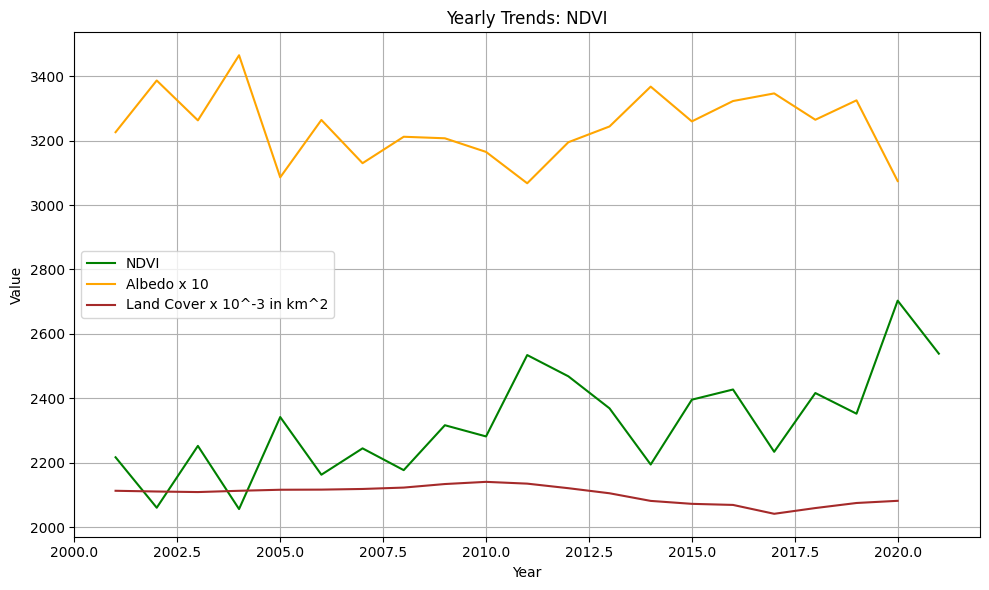

In [151]:
#Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(ndvi_df['year'], ndvi_df['mean_ndvi'], label='NDVI', color='green')
plt.plot(albedo_yearly['year'], albedo_yearly['mean_albedo']*10, label='Albedo x 10', color='orange')
plt.plot(lc_df['year'], lc_df['green_area_km2']/1e3, label='Land Cover x 10^-3 in km^2', color='brown')
plt.title('Yearly Trends: NDVI')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Plotting OLR difference

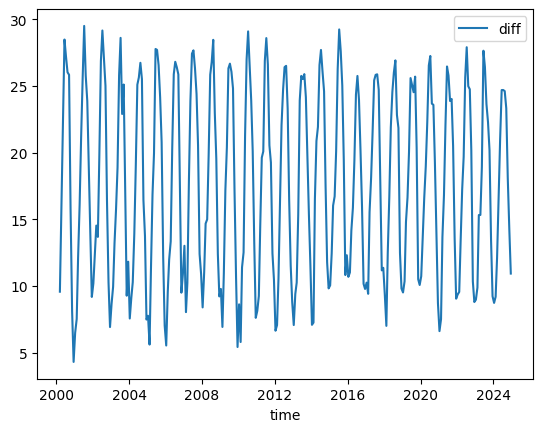

In [123]:
diff=ds['toa_lw_clr_c_mon'].mean(dim=['lat', 'lon'])-ds['toa_lw_all_mon'].mean(dim=['lat', 'lon'])
diff.plot(label='diff')
plt.legend()

Doing Monthly mean for OLR difference

In [ ]:
diff=olr_clr-olr
monthly_diff = diff.mean(dim=['lat', 'lon'])
#Monthly average across years
diff_monthly_avg = monthly_diff.groupby('time.year').mean(dim='time')
print(diff_monthly_avg)

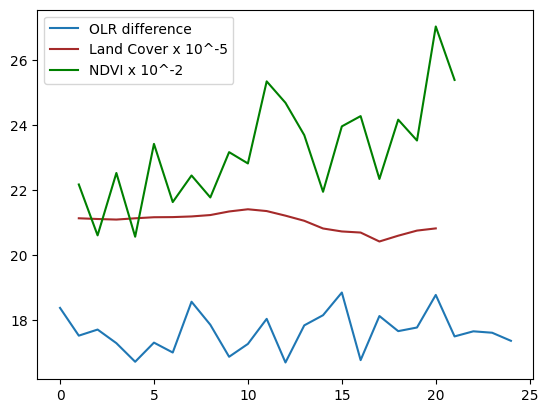

In [166]:
#Plotting
plt.plot(diff_monthly_avg,label='OLR difference')
plt.plot(lc_df['year']-2000,lc_df['green_area_km2']/1e5, label='Land Cover x 10^-5', color='brown')
plt.plot(ndvi_df['year']-2000, ndvi_df['mean_ndvi']/100, label='NDVI x 10^-2', color='green')
plt.legend()
plt.show()

In [171]:
ndvi=ndvi_df['mean_ndvi']

Making maps for mean seasonal albedo

C:\Users\ritob\AppData\Local\Temp\ipykernel_12748\2022604784.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


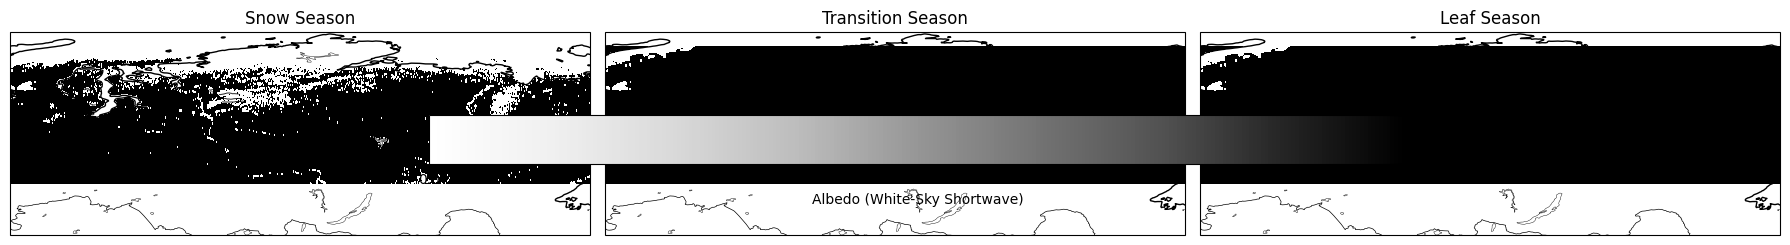

In [179]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
import numpy as np

# File paths for each seasonal TIFF
files = {
    'Snow Season': 'albedo_snow.tif',
    'Transition Season': 'albedo_transition.tif',
    'Leaf Season': 'albedo_leaf.tif'
}

# Create 3 subplots with Cartopy
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

for ax, (season, file) in zip(axes, files.items()):
    with rasterio.open(file) as src:
        # Read and scale albedo values
        albedo = src.read(1).astype('float32')
        
        # Mask invalid values
        albedo = np.where((albedo < 0) | (albedo > 10000), np.nan, albedo)
        
        # Scale to 0–1
        albedo = albedo*10000.0
        
        # Get spatial extent
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Plot albedo
    img = ax.imshow(
        albedo,
        extent=extent,
        transform=ccrs.PlateCarree(),
        cmap='Greys',  # or try 'YlGnBu', 'viridis', etc.
        vmin=0.0,
        vmax=1.0
    )

    # Add map features
    ax.set_title(season)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none', linewidth=0.3)
    ax.set_extent([60, 140, 50, 75])  # Siberia region

# Shared colorbar
cbar = fig.colorbar(img, ax=axes.ravel().tolist(), orientation='horizontal', shrink=0.7)
cbar.set_label('Albedo (White-Sky Shortwave)')

plt.tight_layout()
plt.show()